In [ ]:
##미세조정

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,Sequential
import zipfile
from keras import optimizers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array


In [2]:
train_path = '/Users/bh/kears/iamge/train'

In [3]:
classes = 3
height = 128
width = 128
channels = 3

In [4]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/128, 
                                                                  validation_split=0.2,
                                                                  rotation_range=40,
                                                                  width_shift_range=0.2,
                                                                  height_shift_range=0.2,
                                                                  shear_range=0.2,
                                                                  zoom_range=0.2,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True,
                                                                  fill_mode='nearest')
                                                                 
image_data_train = image_generator.flow_from_directory(train_path,subset='training')
image_data_test = image_generator.flow_from_directory(train_path,subset='validation')

Found 1046 images belonging to 3 classes.
Found 259 images belonging to 3 classes.


In [5]:
## Data augument 한 사진 저장하기
#img = load_img('/Users/bh/adl.png')  
#x = img_to_array(img)  
#x = x.reshape((1,) + x.shape)  


#i = 0
#for batch in image_generator.flow(x, batch_size=1,
#                          save_to_dir='/Users/bh/adle aug' , save_prefix='adel', save_format='jpg'):
#    i += 1
#    if i > 20:
#        break 

In [6]:
resnet50 = tf.keras.applications.resnet50.ResNet50(
           include_top=False,
           weights=None,##이미지넷 적용을 해제
           input_tensor=None,
           input_shape=(height,width,channels),
           pooling=None,
           classes=3,
           #**kwargs
)

In [7]:
resnet50.trainable=True

In [8]:
print("Number of layers in the base model: ", len(resnet50.layers)) ##resnet50의 레이어 개수 확인

Number of layers in the base model:  175


In [9]:
## 175개의 레이어중 90개의 입력쪽(하단)레이어를 얼려준다.
fine_tune_at = 90

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet50.layers[:fine_tune_at]:
  layer.trainable = False

In [10]:
model = Sequential([
                 resnet50,
                 Dense(512,activation='relu'),
                 BatchNormalization(),
                 GlobalAveragePooling2D(),
                 Dense(classes,activation='softmax')
])

In [11]:
model.load_weights('/Users/bh/kears/gentootse/pretrain4/weight')##pretrain에서 학습한 가중치 불러오기

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dense (Dense)               (None, 4, 4, 512)         1049088   
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24640387 (94.00 MB)
Trainable params: 2162

In [13]:
model.compile(optimizer=optimizers.legacy.Adam(learning_rate=0.00003),loss='categorical_crossentropy',metrics='accuracy')
##콜백 함수로 fit에 넣어주면 학습중 학습률를 변경할 수 있다.
##사용하지 않음
#def scheduler(epoch, lr):
#    if epoch < 2:
#        return lr
#    else:
#        return lr * tf.math.exp(-0.1)
#lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)
#model.fit(image_data_train,batch_size=32,epochs=5,callbacks=[lrs],validation_data=(image_data_test),
#          validation_steps =image_data_test.samples/image_data_test.batch_size)
hist = model.fit(image_data_train,batch_size=32,epochs=50,validation_data=(image_data_test),
          validation_steps =image_data_test.samples/image_data_test.batch_size)

Epoch 1/50
33/33 [==============================] - 30s 843ms/step - loss: 1.0396 - accuracy: 0.4837 - val_loss: 1.7126 - val_accuracy: 0.5212
Epoch 2/50
33/33 [==============================] - 27s 811ms/step - loss: 0.9504 - accuracy: 0.5249 - val_loss: 1.5501 - val_accuracy: 0.5251
Epoch 3/50
33/33 [==============================] - 27s 819ms/step - loss: 0.8697 - accuracy: 0.5937 - val_loss: 1.3359 - val_accuracy: 0.5135
Epoch 4/50
33/33 [==============================] - 28s 850ms/step - loss: 0.8300 - accuracy: 0.6262 - val_loss: 1.1083 - val_accuracy: 0.5174
Epoch 5/50
33/33 [==============================] - 29s 867ms/step - loss: 0.8130 - accuracy: 0.6300 - val_loss: 0.9653 - val_accuracy: 0.5174
Epoch 6/50
33/33 [==============================] - 30s 895ms/step - loss: 0.7849 - accuracy: 0.6424 - val_loss: 0.8807 - val_accuracy: 0.5753
Epoch 7/50
33/33 [==============================] - 30s 901ms/step - loss: 0.7480 - accuracy: 0.6692 - val_loss: 0.8125 - val_accuracy: 0.6293

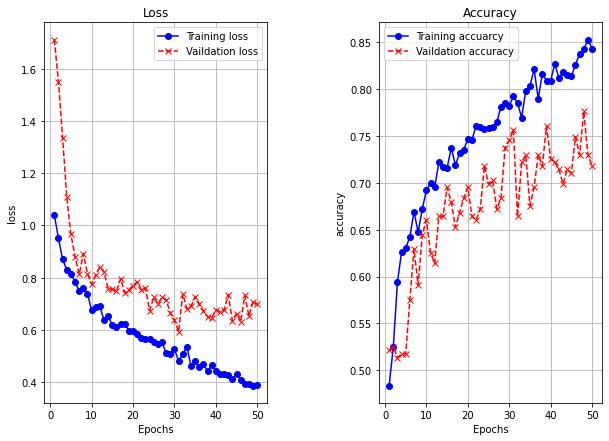

In [14]:
import matplotlib.pyplot as plt

loss = hist.history['loss']
acc = hist.history['accuracy']

val_loss = hist.history['val_loss']
val_acc = hist.history['val_accuracy']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rx--', label='Vaildation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo-', label='Training accuarcy')
plt.plot(epochs, val_acc, 'rx--', label='Vaildation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

In [15]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import numpy as np

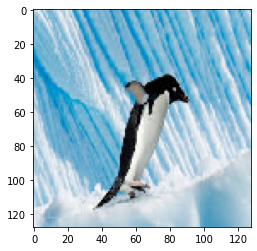

numpy array size :  (128, 128, 3)
1/1 [==============================] - 1s 949ms/step
결과 :  adelie penguin


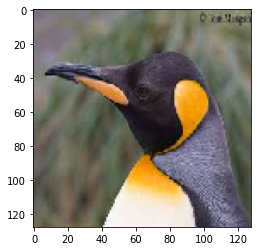

numpy array size :  (128, 128, 3)
1/1 [==============================] - 0s 46ms/step
결과 :  king penguin


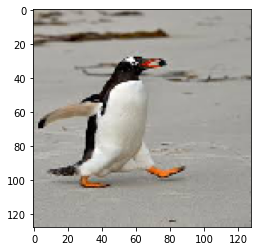

numpy array size :  (128, 128, 3)
1/1 [==============================] - 0s 32ms/step
결과 :  adelie penguin


In [16]:
img_height = 128
img_width = 128

filename = ['/Users/bh/kears/iamge/test/adélie penguin/adélie_penguin_111.jpg','/Users/bh/kears/iamge/test/king penguin/king penguin44.jpg','/Users/bh/kears/iamge/test/gentoo penguin/gentoo_penguin_45.jpg']

predict_dictionary = {0:'adelie penguin',1:'gentoo penguin',2: 'king penguin'}

for file in filename:
    original = load_img(file, target_size = (img_height,img_width))

    numpy_image = img_to_array(original)
    plt.imshow(np.uint8(numpy_image))
    plt.show()
    print("numpy array size : ", numpy_image.shape)
    image_batch = np.expand_dims(numpy_image , axis = 0)

    predict = np.argmax(model.predict(image_batch/128.))

    print('결과 : ',predict_dictionary[predict])

In [17]:
model.save_weights('/Users/bh/kears/fintuningmidd/weight')

In [18]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./128)
test_dir = '/Users/bh/kears/iamge/test'
test_Gen = test_datagen.flow_from_directory(test_dir, batch_size = 32)
loss, accuracy = model.evaluate(test_Gen,
                                steps = test_Gen.samples/test_Gen.batch_size)

print('Loss = {:.5f}'.format(loss))
print('Acc - {:.5f}'.format(accuracy))

Found 326 images belonging to 3 classes.
10/10 [==============================] - 4s 425ms/step - loss: 0.4877 - accuracy: 0.8160
Loss = 0.48766
Acc - 0.81595


In [19]:
len(model.trainable_variables) ##현재 un-freeze된 레이어 확인

108

In [20]:
resnet50.trainable=True ##모든 레이어 un-freeze

In [21]:
len(model.trainable_variables) ##un-freeze가 잘되엇는지 확인

218

In [22]:
model.compile(optimizer=optimizers.legacy.Adam(learning_rate=0.00002),loss='categorical_crossentropy',metrics='accuracy')
## 학습률 변경

In [23]:
fine_tune_epochs = 50
total_epochs =  50 + fine_tune_epochs

hist_50 = model.fit(image_data_train,batch_size=32,
                    epochs=total_epochs,
                    initial_epoch=hist.epoch[-1],
                    validation_data=(image_data_test),
                     validation_steps =image_data_test.samples/image_data_test.batch_size)

Epoch 50/100
33/33 [==============================] - 59s 2s/step - loss: 0.8225 - accuracy: 0.6520 - val_loss: 1.0361 - val_accuracy: 0.6371
Epoch 51/100
33/33 [==============================] - 53s 2s/step - loss: 0.4682 - accuracy: 0.8241 - val_loss: 1.1305 - val_accuracy: 0.5405
Epoch 52/100
33/33 [==============================] - 53s 2s/step - loss: 0.3271 - accuracy: 0.8652 - val_loss: 1.1802 - val_accuracy: 0.5405
Epoch 53/100
33/33 [==============================] - 53s 2s/step - loss: 0.2704 - accuracy: 0.8977 - val_loss: 1.1737 - val_accuracy: 0.5483
Epoch 54/100
33/33 [==============================] - 53s 2s/step - loss: 0.2019 - accuracy: 0.9331 - val_loss: 0.9850 - val_accuracy: 0.5598
Epoch 55/100
33/33 [==============================] - 52s 2s/step - loss: 0.1709 - accuracy: 0.9340 - val_loss: 1.0866 - val_accuracy: 0.5483
Epoch 56/100
33/33 [==============================] - 53s 2s/step - loss: 0.1419 - accuracy: 0.9484 - val_loss: 1.1920 - val_accuracy: 0.5058
Epoch 

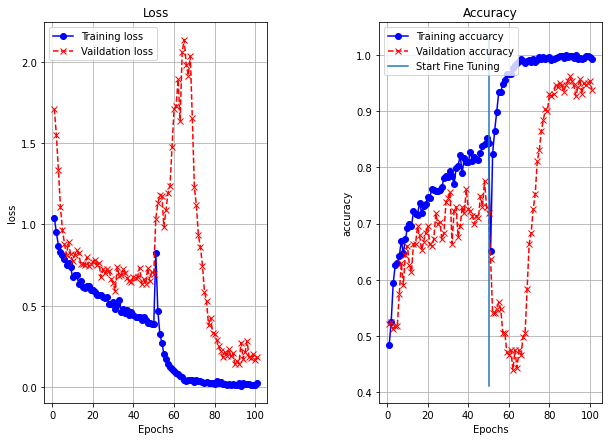

In [24]:
##위의 그래프와 방금 학습한 학습 그래프를 합쳐보았음
loss = hist.history['loss'] + hist_50.history['loss']
acc = hist.history['accuracy'] + hist_50.history['accuracy']

val_loss = hist.history['val_loss'] + hist_50.history['val_loss']
val_acc = hist.history['val_accuracy'] + hist_50.history['val_accuracy']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rx--', label='Vaildation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo-', label='Training accuarcy')
plt.plot(epochs, val_acc, 'rx--', label='Vaildation accuracy')
plt.plot([50,50],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

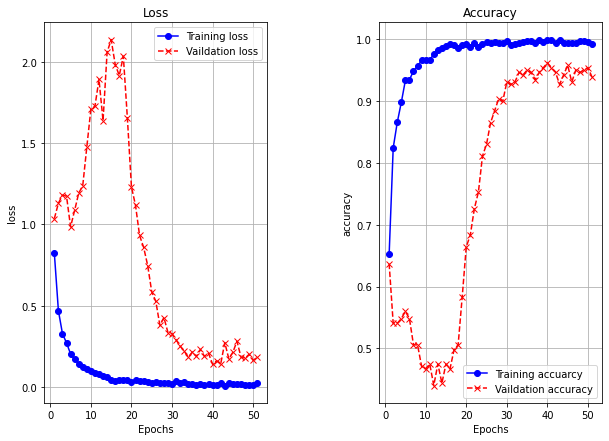

In [25]:
## 방금 학습한 그래프만을 출력
loss = hist_50.history['loss']
acc = hist_50.history['accuracy']

val_loss =  hist_50.history['val_loss']
val_acc = hist_50.history['val_accuracy']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rx--', label='Vaildation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo-', label='Training accuarcy')
plt.plot(epochs, val_acc, 'rx--', label='Vaildation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

In [26]:
model.save_weights('/Users/bh/kears/fintunigfinal/weight')

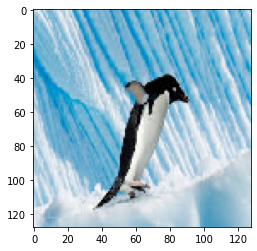

numpy array size :  (128, 128, 3)
1/1 [==============================] - 1s 863ms/step
결과 :  adelie penguin


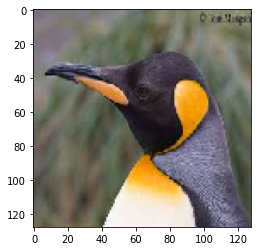

numpy array size :  (128, 128, 3)
1/1 [==============================] - 0s 51ms/step
결과 :  king penguin


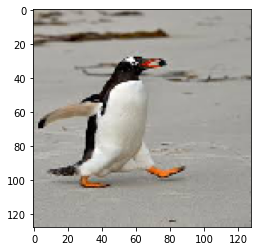

numpy array size :  (128, 128, 3)
1/1 [==============================] - 0s 28ms/step
결과 :  gentoo penguin


In [27]:
##이미지 예측
img_height = 128
img_width = 128

filename = ['/Users/bh/kears/iamge/test/adélie penguin/adélie_penguin_111.jpg','/Users/bh/kears/iamge/test/king penguin/king penguin44.jpg','/Users/bh/kears/iamge/test/gentoo penguin/gentoo_penguin_45.jpg']

predict_dictionary = {0:'adelie penguin',1:'gentoo penguin',2: 'king penguin'}

for file in filename:
    original = load_img(file, target_size = (img_height,img_width))

    numpy_image = img_to_array(original)
    plt.imshow(np.uint8(numpy_image))
    plt.show()
    print("numpy array size : ", numpy_image.shape)
    image_batch = np.expand_dims(numpy_image , axis = 0)

    predict = np.argmax(model.predict(image_batch/128.))

    print('결과 : ',predict_dictionary[predict])

In [28]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./128)
test_dir = '/Users/bh/kears/iamge/test'
test_Gen = test_datagen.flow_from_directory(test_dir, batch_size = 32)
loss, accuracy = model.evaluate(test_Gen,
                                steps = test_Gen.samples/test_Gen.batch_size)

print('Loss = {:.5f}'.format(loss))
print('Acc - {:.5f}'.format(accuracy))

Found 326 images belonging to 3 classes.
10/10 [==============================] - 4s 420ms/step - loss: 0.1476 - accuracy: 0.9601
Loss = 0.14762
Acc - 0.96012
